Представлены данные такси, по которым мы должны предсказать возьмёт ли таксист заказ или нет(driver_response).

Принципы вы знаете, чек-лист аналогичен лабораторной работе.

Чек-лист:
1. Загрузите датасет taxi.csv.
2. Посмотрите на данные. Отобразите общую информацию по признакам (вспомните о describe и info). Напишите в markdown свои наблюдения.
3. Выявите пропуски, а также возможные причины их возникновения. Решите, что следует сделать с ними. Напишите в markdown свои наблюдения.
4. Оцените зависимости переменных между собой. Используйте корреляции. Будет хорошо, если воспользуетесь profile_report. Напишите в markdown свои наблюдения.
5. Определите стратегию преобразования категориальных признаков (т.е. как их сделать адекватными для моделей).
6. Найдите признаки, которые можно разделить на другие, или преобразовать в другой тип данных. Удалите лишние, при необходимости.
7. Разделите выборку на обучаемую и тестовую.
8. Обучите модель. Напишите в markdown свои наблюдения по полученным результатам. Хорошие результаты дают классификаторы RandomForest и XGBoost



In [1]:
import pandas as pd
import pandas_profiling
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import sys
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report

In [312]:
data = pd.read_csv('E:\\Netology\\DVP\\taxi.csv', sep=',')
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [313]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


In [292]:
data.describe()


,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.662189e+05,3.159860,13.827790,3446.376360,460867.01291,55.700824,37.492292,55.772440,37.541637,18.393518,23.134841,0.492480
std,3.259360e+05,2.054222,7.306496,2038.738677,266064.98953,2.135903,1.454640,0.665985,0.467758,41.129296,33.890105,0.499946
min,4.000000e+00,0.000000,0.000000,14.000000,18.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2.855552e+05,1.000000,8.000000,1421.000000,229178.50000,55.708651,37.413497,55.708032,37.407117,-1.000000,-1.000000,0.000000
50%,5.656715e+05,3.000000,16.000000,3506.500000,462420.00000,55.772904,37.533664,55.772561,37.532537,10.411500,19.700000,0.000000
75%,8.487198e+05,5.000000,20.000000,5242.000000,690894.00000,55.960667,37.624113,55.962000,37.624358,30.665250,37.867000,1.000000
max,1.130355e+06,6.000000,23.000000,6806.000000,920344.00000,56.174097,38.280547,56.311121,38.243608,5234.283000,3958.283000,1.000000


Видим, что явных пропусков нет, но в геопозиции, расстоянии и времени есть значение -1, что по сути незаполненное значение.
Есть подозрение на выброс в distance_km и duration_min
Попробуем поизучать и понять что делать с этими данными. Может быть их удалим, может заполним, а может оставим как есть 

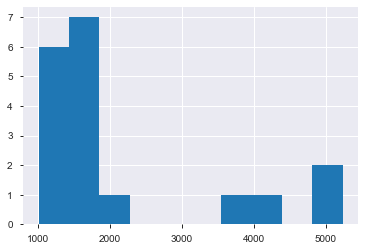

In [4]:
import matplotlib.pyplot as plt
plt.hist(data.distance_km[data.distance_km > 1000])
plt.show()

In [4]:
data[data.distance_km > 1000].shape

(18, 14)

18 выбросов. Разберемся что будем делать с -1 и решим что этими выбросами делаем

In [5]:
data[data.distance_km < 0].shape

(26207, 14)

In [6]:
data[data.driver_latitude < 0].groupby(['ride_type_desc']).count().head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,driver_response
ride_type_desc,,,,,,,,,,,,,
business,130,130,130,130,130,130,130,130,130,130,130,130,130
private,10,10,10,10,10,10,10,10,10,10,10,10,10


Там, где не определилось положение водителя, сильный перевес в сторону бизнесовых поездок. Пллюс среди них есть те, которые с определившимся расстоянием и с -1. Оставим все записи на сейчас.

In [314]:
# выбросы в расстоянии заменим на -1. Пусть будут как-будто не определились
data.loc[data['distance_km'] > 1000,['distance_km']] = -1
data.loc[data['duration_min'] > 1000,['duration_min']] = -1


In [5]:
data.profile_report()

In [ ]:
По профайлу видим, что у нас 17 дубликатов. Ок. удалим их.
Время и дни недели не везде заполнены. Но их много, поэтому удалять думаю неправильно

In [315]:
data.drop_duplicates(inplace=True)

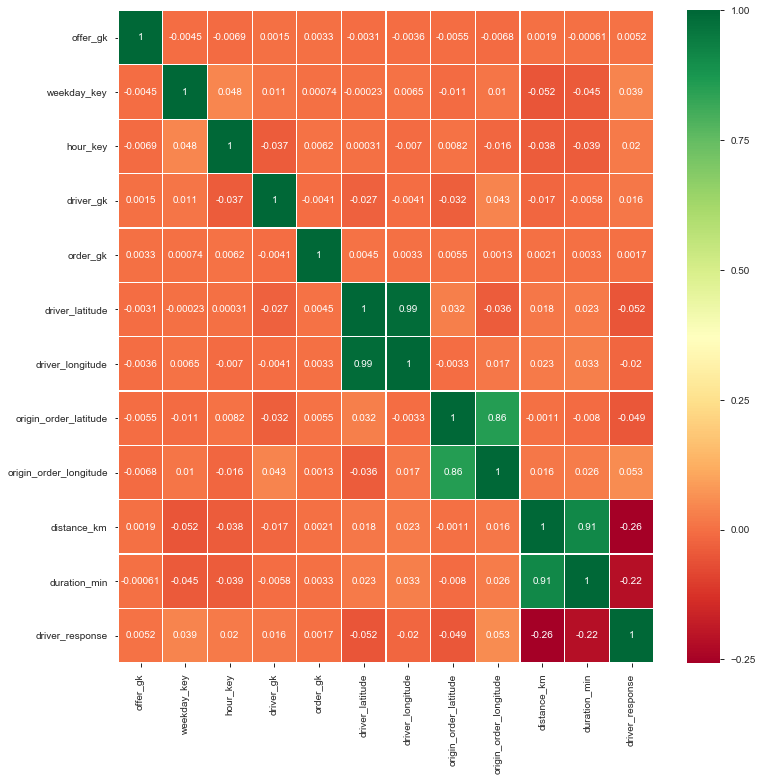

In [19]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(12,12)
plt.show()

Очень сильно коррелируют широта и долгота. проверим потом можно ли обойтись одним из них. но мне кажется, что т.к. это координаты, то убирать что-то будет не правильно
Разберемся с категориальными признакми у нас их всего 2 и количество вариаций небольшое, поэтому применим one hot encoding

In [316]:
# преобразуем колонку  в one-hot encoding вектор
one_hot = pd.get_dummies(data['offer_class_group'])
# Удаляем колонку species
#data = data.drop('sex',axis = 1)
# добавляем колонку one-hot к исходной таблице
data = data.join(one_hot)
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,...,driver_response,Delivery,Economy,Kids,Premium,Standard,Test,VIP,VIP+,XL
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,...,0,0,1,0,0,0,0,0,0,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,...,1,0,0,0,0,1,0,0,0,0
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,...,0,0,1,0,0,0,0,0,0,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,...,1,0,1,0,0,0,0,0,0,0
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,...,1,0,1,0,0,0,0,0,0,0


In [317]:
# преобразуем колонку в one-hot encoding вектор
one_hot = pd.get_dummies(data['ride_type_desc'])
# Удаляем колонку species
#data = data.drop('sex',axis = 1)
# добавляем колонку one-hot к исходной таблице
data = data.join(one_hot)
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,...,Premium,Standard,Test,VIP,VIP+,XL,SMB,affiliate,business,private
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,...,0,0,0,0,0,0,0,0,0,1
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,...,0,1,0,0,0,0,0,0,0,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,...,0,0,0,0,0,0,0,0,0,1
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,...,0,0,0,0,0,0,0,0,0,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,...,0,0,0,0,0,0,0,0,0,1


In [294]:
# Кодируем категориальные переменные
#Такой подход дал хуже результаты чем onehotencoding, поэтому не будем использовать
from sklearn.preprocessing import LabelEncoder
labelEnc = LabelEncoder()
columns_for_encode = ['offer_class_group', 'ride_type_desc']
for column in columns_for_encode:
    data[column + "_enc"] = labelEnc.fit_transform(data[column])

In [22]:
data.columns

Index(['offer_gk', 'weekday_key', 'hour_key', 'driver_gk', 'order_gk',
       'driver_latitude', 'driver_longitude', 'origin_order_latitude',
       'origin_order_longitude', 'distance_km', 'duration_min',
       'offer_class_group', 'ride_type_desc', 'driver_response', 'Delivery',
       'Economy', 'Kids', 'Premium', 'Standard', 'Test', 'VIP', 'VIP+', 'XL',
       'SMB', 'affiliate', 'business', 'private'],
      dtype='object')

In [318]:
# Здесь было много итераций по подбору оптимального набора признаков.
# большим вопросом остается влияние 'driver_gk'. Если смотреть на значимость переменных, то деревья выдают его как самого 
# важного. Но с другой стороны это просто идентификатор водителя

X = data[['weekday_key', 'hour_key','driver_gk',
        'distance_km', 'duration_min','origin_order_latitude',
       'origin_order_longitude',
        'Delivery', 'driver_latitude', 'driver_longitude',
       'Economy', 'Kids', 'Premium', 'Standard', 'Test', 'VIP', 'VIP+', 'XL',
       'SMB', 'affiliate', 'business', 'private']]
y = data['driver_response']

In [319]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [320]:

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R2: \t", r2_score(y_test, y_pred))
print("RMSE: \t", sqrt(mean_squared_error(y_test, y_pred)))

print("MAE: \t", mean_absolute_error(y_test, y_pred))
model.score(X_test, y_test)



R2: 	 0.12588511305602945
RMSE: 	 0.46736048051393314
MAE: 	 0.4402018271628768


0.12588511305602945

In [321]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression()
model.fit(X_train, y_train)

model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))


              precision    recall  f1-score   support

           0       0.71      0.54      0.62     10217
           1       0.62      0.77      0.69      9783

    accuracy                           0.65     20000
   macro avg       0.66      0.66      0.65     20000
weighted avg       0.67      0.65      0.65     20000



C:\Users\pgridchina\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [322]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print("R2: \t", r2_score(y_test, y_pred))
print("RMSE: \t", sqrt(mean_squared_error(y_test, y_pred)))

print("MAE: \t", mean_absolute_error(y_test, y_pred))



R2: 	 0.24784581811729356
RMSE: 	 0.4335320057389074
MAE: 	 0.18795


АБСОЛЮТНО НЕ ПОНИМАЮ ПОЧЕМУ ПРОИСХОДИТ ТАКАЯ РАЗНИЦА МЕЖДУ ЛИНЕЙНОЙ И ЛОГИСТИЧЕСКОЙ РЕГРЕССИЕЙ И ПОЧЕМУ СЛУЧАЙНЫЙ ЛЕС ВЫДАЕТ ТАКОЙ УЖАС

No handles with labels found to put in legend.


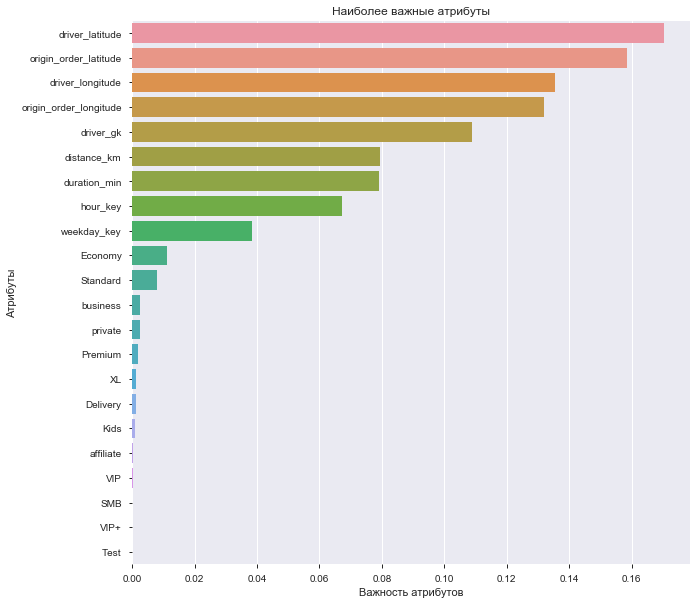

In [323]:
headers = list(X_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

In [324]:
import xgboost
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.39%


Теперь пробуем не просто заменить категориальный переменные цифрами, а придать им вес

In [325]:
data['class'] = data['offer_class_group'].map((data.groupby(['offer_class_group'])['driver_response'].sum()) / data.groupby(['offer_class_group'])['driver_response'].count())

In [326]:
data['desc'] = data['ride_type_desc'].map((data.groupby(['ride_type_desc'])['driver_response'].sum()) / data.groupby(['ride_type_desc'])['driver_response'].count())

In [332]:
# Там, где нет расстояния и времени заменим на средние значения
data.loc[data['distance_km'] <= 0,['distance_km']] = df1['distance_km'].mean()
data.loc[data['duration_min'] <= 0,['duration_min']] = df1['duration_min'].mean()

In [333]:
#Добавим колонку со скоростью. Она может отражать загруженность дорог
data['speed'] = data.apply(lambda x: x['distance_km'] / x['duration_min'] ,axis=1)

Добавим расстояние от водителя до клиента. Ведь наверное чем  ближе заказ, тем больше шанс, что его возьмут

In [328]:
import math
def haversine(coord1, coord2):
    R = 6372.8  # Earth radius in km
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [329]:
data['dest'] = data.apply(lambda x:haversine((x['driver_latitude'],x['driver_longitude']),(x['origin_order_latitude'],x['origin_order_longitude'])) ,axis=1)

In [330]:
data.columns

Index(['offer_gk', 'weekday_key', 'hour_key', 'driver_gk', 'order_gk',
       'driver_latitude', 'driver_longitude', 'origin_order_latitude',
       'origin_order_longitude', 'distance_km', 'duration_min',
       'offer_class_group', 'ride_type_desc', 'driver_response', 'Delivery',
       'Economy', 'Kids', 'Premium', 'Standard', 'Test', 'VIP', 'VIP+', 'XL',
       'SMB', 'affiliate', 'business', 'private', 'class', 'desc', 'dest'],
      dtype='object')

In [352]:
# Не будем брать колонки с VIP  и т.д., которые показывают самую незначительную важность
X = data[['weekday_key', 'hour_key', 'driver_gk', 'distance_km', 'duration_min',
        'driver_latitude', 'driver_longitude','class','desc','origin_order_latitude',
       'origin_order_longitude', 'dest',
          'Delivery','Economy', 'Premium', 'Standard', 'business', 'private','speed']]
y = data['driver_response']

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [354]:
import xgboost
model = xgboost.XGBClassifier(n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.77%


In [344]:
model=RandomForestClassifier(n_estimators=100,random_state=2)
# обучаем модель
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print("R2: \t", r2_score(y_test, y_pred))
print("RMSE: \t", sqrt(mean_squared_error(y_test, y_pred)))

print("MAE: \t", mean_absolute_error(y_test, y_pred))

R2: 	 0.23323893988440247
RMSE: 	 0.43772137256478577
MAE: 	 0.1916


No handles with labels found to put in legend.


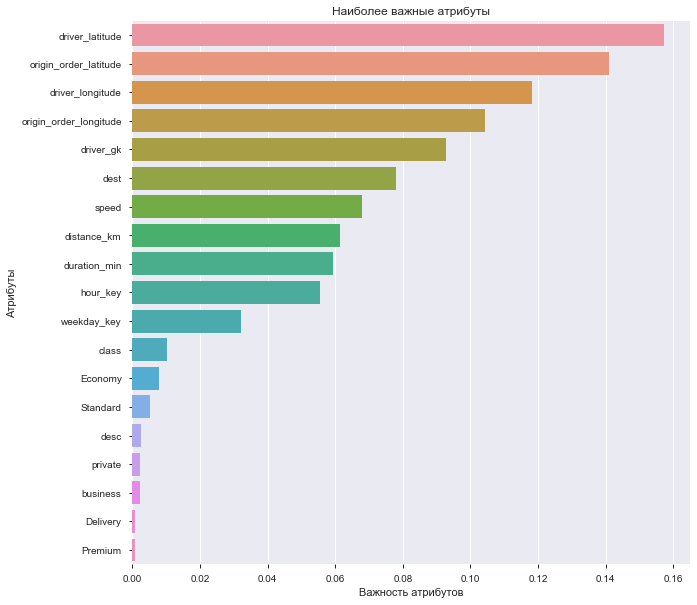

In [345]:
headers = list(X_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

In [346]:
# RFClassifier  и Regressor дают тоже разные результаты. Для меня это пока совсем не понятно
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=2)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R2: \t", r2_score(y_test, y_pred))
print("RMSE: \t", sqrt(mean_squared_error(y_test, y_pred)))

print("MAE: \t", mean_absolute_error(y_test, y_pred))

R2: 	 0.4743702590519907
RMSE: 	 0.362416275558678
MAE: 	 0.26118850569762175


No handles with labels found to put in legend.


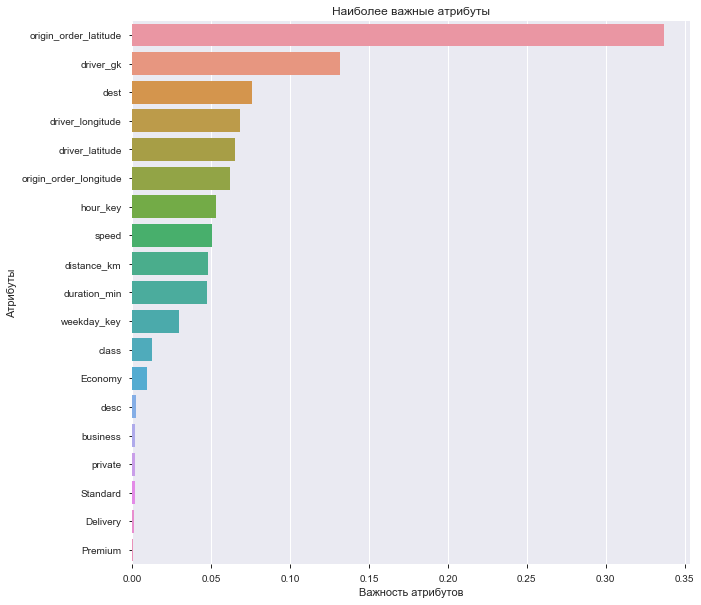

In [347]:
headers = list(X_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

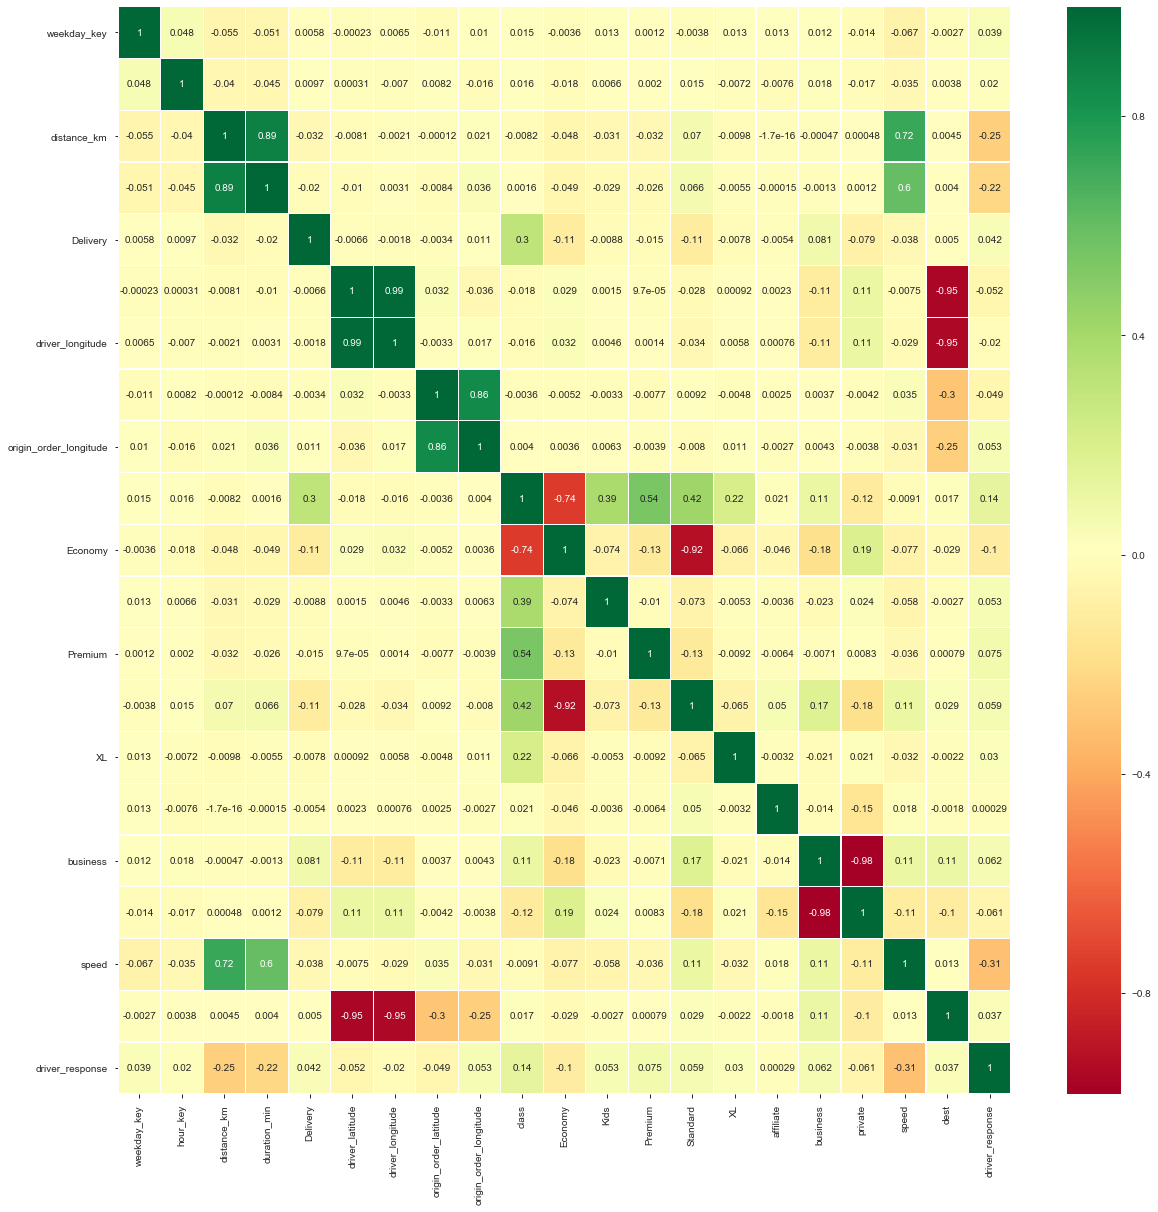

In [255]:
df = data[['weekday_key', 'hour_key', 'distance_km', 'duration_min',
        'Delivery', 'driver_latitude', 'driver_longitude', 'origin_order_latitude',
       'origin_order_longitude','class',
       'Economy', 'Kids', 'Premium', 'Standard', 'XL',
       'affiliate', 'business', 'private','speed','dest','driver_response']]
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [348]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression()
model.fit(X_train, y_train)

model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))


              precision    recall  f1-score   support

           0       0.65      0.60      0.62     10217
           1       0.61      0.67      0.64      9783

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



C:\Users\pgridchina\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Выводы:
Напридуманные колонки не дали почти никакого результата.
one-hot здесь показал себя чуть лучше
с деревьями решений справится не получилось, хотя заявлено, что они дают лучший результат.
XGBoost показал лучший результат
Огромная просьба выложить правильный подход к этой задаче, чтобы понимать что делаю неправильно.